# ET 2: Reconstruction of Images and Parameter Maps

## ESMRMB 2024

- October 5th 2024

Based off of previous tutorials from other contributors:

### MRITogether 2023
[MRITogether 2023 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2023),
[Jon Tamir](mailto:jtamir@utexas.edu), University of Texas at Austin

### MRITogether 2021
[MRITogether 2021 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2021).

The purpose of this notebook is to introduce the [BART toolbox](https://mrirecon.github.io/bart), and its use as a tool for reconstruction of low-field parameter maps.

We recommend checking other points of reference, primarily available in the following locations:
- [BART Workshops](https://github.com/mrirecon/bart-workshop)
- [BART Webinars](https://github.com/mrirecon/bart-webinars) (and [webinar recordings](https://www.youtube.com/@bart-toolboxdepartmental7435/playlists)\)


## Table of Contents
- BART Setup and Basics
- Data Exploration
- Basic Parameter Map
  - Pixel-wise fit
  - Model-based reconstruction
- Retrospective Undersampling Pattern
- Subspace Reconstruction
- (Bonus) Motion Correction

## Installation

You can find more information on BART on the [Website](https://mrirecon.github.io/bart/). For this workshop we will be using BART version `v0.9.00-566-g0759d7e`.


### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `BART_TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export BART_TOOLBOX_PATH=/path/to/bart  
export PATH=$BART_TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$BART_TOOLBOX_PATH/matlab` and `$BART_TOOLBOX_PATH/python` directories.

### Online Usage
We recommend running BART locally when possible. For demonstration purposes, Google Colaboratory can be used to access a Jupyter instance with BART with a browser. In the following we install and configure BART.

#### BART Installation

Here we install BART's dependencies, clone its repository from github, and compile it (2min 30sec).

---
**💡Hint:💡**

- **`%%bash` Cells in Google Colab:**

  In Google Colab, `%%bash` cells allow you to run bash commands directly within your notebook.

  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.

  If you only have a single command you can also prefix it with `!` for the same effect.


In [ ]:
%%bash

# Install BART's dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone BART (delete previous version)
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null


In [ ]:
%%bash

cd bart

# Configuration
COMPILE_SPECS=" PARALLEL=1
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART
make &> /dev/null && echo ok


#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BART's command line interface inside an ipython jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [ ]:
import sys, os
os.environ['BART_TOOLBOX_PATH'] = f"{os.getcwd()}/bart"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [ ]:
%%bash
echo "# BART version: "
bart version

## BART Fundamentals
BART provides a number of tools for MR image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.



In [ ]:
# get a list of BART commands by running bart with no arguments:
! bart

### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by `<,>` symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [ ]:
! bart phantom -h

The `phantom` tool includes the option `-k` to create it in k-space, and `-x` to specify the size.

## Python Bindings

BART comes equipped with Python bindings that easily integrate with popular scientific computing libraries in Python. In this tutorial we will primarily use the python bindings for plotting.




<details>
  <summary>If you are interested you can find a more detailed explanation of the Python bindings by expanding this cell.</summary>

If you're running in Colab, the paths should be updated and you should be all set to run the following demos.

If you are running locally, you will need to directly import the bart module. To do this, you can add BART's python directory to your `PYTHONPATH` environment variable. Add the following line to your .bashrc to do this:

```bash
export PYTHONPATH="${BART_TOOLBOX_PATH}/python:$PYTHONPATH"
```

Where `BART_TOOLBOX_PATH` is the location of your BART install.

This way, we can import the bart module as well as cfl, our utility file for dealing with BART's data format: a .hdr header file and a .cfl file of complex-float data.

If you're already running the demo in Colab, you may have to manually modify the path, which we do here:
</details>

In [ ]:
# we can use pip install to install the Python bindings using the package description in the pkg/python subdirectory
%%bash
pip install bart/pkg/python

After having updated your `PYTHONPATH`, the following cells should execute error-free:

In [ ]:
from bart import bart
import cfl

Now we can run bart commands directly from Python (although we will not use it in this notebook)

In [ ]:
A = bart(1, 'ones 2 5 5')
A

### Setup Visualization Helper

For this tutorial we will visualize some images. Therefore, we need a helper function and some python libraries.


In [ ]:
#@title Visualization  Python Method
# Note:  Viewer doesn't work in private windows with firefox
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from ipywidgets import widgets, HBox, VBox, Layout, IntText, Dropdown, interactive_output, FloatSlider
from IPython.display import display
from traitlets import List, Bool

# Set Plotly renderer to work with Google Colab
pio.renderers.default = "colab"

# Required to enable Plotly in Google Colab
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)

enable_plotly_in_cell()

class DimensionSelector(HBox):
    value = List(Bool()).tag(sync=True)

    def __init__(self, n_dims):
        self.checkboxes = [widgets.Checkbox(value=i < 2, description=f'Dim {i}') for i in range(n_dims)]
        super().__init__(self.checkboxes)
        for cb in self.checkboxes:
            cb.observe(self.on_change, 'value')
        self.value = [cb.value for cb in self.checkboxes]

    def on_change(self, change):
        selected = [cb for cb in self.checkboxes if cb.value]
        if len(selected) > 2:
            selected[0].value = False
        self.value = [cb.value for cb in self.checkboxes]

def interactive_bart_plot(data, cmap='Greys_r', cbar_label='', mag=True, fsize=6):
    if isinstance(data, str):
        data = cfl.readcfl(data)
    else:
        data = np.array(data)
    if mag:
        data = np.abs(data)

    # Initialize the plot
    fig = go.Figure()

    # Create slice widgets
    def create_slice_widget(i):
        widget = IntText(value=0, description=f'Dim {i}:', layout=Layout(width='200px'))

        def on_value_change(change):
            if change['new'] < 0:
                widget.value = 0
            elif change['new'] >= data.shape[i]:
                widget.value = data.shape[i] - 1
            update_plot(dim_selector.value, interpolation_widget.value, vmin_widget.value, vmax_widget.value, slice_update=True, **slice_widgets_values())

        widget.observe(on_value_change, names='value')
        return widget

    slice_widgets = {f'slice_dim{i}': create_slice_widget(i) for i in range(data.ndim)}

    def slice_widgets_values():
        return {f'slice_dim{i}': widget.value for i, widget in enumerate(slice_widgets.values())}

    def update_plot(plot_dims, interpolation, vmin, vmax, slice_update=False, **slice_values):
        selected_dims = [i for i, sel in enumerate(plot_dims) if sel]
        if len(selected_dims) != 2:
            fig.data = []  # Clear current data
            fig.add_annotation(
                text='Please select exactly two dimensions for plotting',
                xref='paper', yref='paper',
                showarrow=False,
                font=dict(size=20)
            )
            fig.update_layout(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                title=None
            )
        else:
            # Create a slice object for indexing
            index = [slice(None)] * data.ndim
            for i in range(data.ndim):
                if i not in selected_dims:
                    index[i] = slice_values[f'slice_dim{i}']

            # Extract the 2D slice to plot
            plot_data = data[tuple(index)].T  # Transpose to match Plotly's default orientation

            # Get the min and max of the current slice data, ignoring NaNs
            current_min = np.nanmin(plot_data)
            current_max = np.nanmax(plot_data)

            # Scale vmin and vmax to the min and max values of the current slice
            abs_vmin = current_min + vmin * (current_max - current_min)
            abs_vmax = current_min + vmax * (current_max - current_min)

            if fig.data:
                # Update existing heatmap trace
                fig.data[0].z = plot_data
                fig.data[0].zmin = abs_vmin
                fig.data[0].zmax = abs_vmax
                fig.data[0].colorscale = cmap
            else:
                # Create the heatmap trace if it doesn't exist
                fig.add_trace(go.Heatmap(z=plot_data, colorscale=cmap, zmin=abs_vmin, zmax=abs_vmax))

            fig.update_layout(
                title=f'Dimensions: {selected_dims}, Interpolation: {interpolation}',
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                autosize=False,
                width=fsize * 100,
                height=fsize * 100
            )
            fig.update_xaxes(scaleanchor="y")

        with output:
            output.clear_output()
            display(fig)

    dim_selector = DimensionSelector(data.ndim)

    interpolation_options = ['nearest', 'linear', 'cubic']
    interpolation_widget = Dropdown(
        options=interpolation_options,
        value='nearest',
        description='Interpolation:',
        layout=Layout(width='200px')
    )

    vmin_widget = FloatSlider(
        value=0.0,
        min=0.0,
        max=1.0,
        step=0.01,
        description='Min Window:',
        layout=Layout(width='400px')
    )

    vmax_widget = FloatSlider(
        value=1.0,
        min=0.0,
        max=1.0,
        step=0.01,
        description='Max Window:',
        layout=Layout(width='400px')
    )

    slice_ui = HBox(list(slice_widgets.values()))
    color_range_ui = VBox([vmin_widget, vmax_widget])
    ui = VBox([dim_selector, interpolation_widget, slice_ui, color_range_ui])

    controls = {'plot_dims': dim_selector, 'interpolation': interpolation_widget, 'vmin': vmin_widget, 'vmax': vmax_widget, **slice_widgets}
    out = interactive_output(update_plot, controls)

    output = widgets.Output()
    display(ui, output)

    # Initial plot update to ensure the plot is shown on first run
    update_plot(dim_selector.value, interpolation_widget.value, vmin_widget.value, vmax_widget.value, **slice_widgets_values())

## File formats and metadata

BART data files are (typically) stored in two files:

* A header (`.hdr`) file which contains metadata (dimensions, file type, etc.)

* A complex float (`.cfl`) file which contains the raw data.

The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in col-major order with interleaved real and imaginary components.

### Writing to and from `.cfl` files

The `cfl` Python library has some helpful tools to save or load BART data into a numpy-compatible format. In the first example, we will create a complex float array in numpy and then load it into BART from the command line. In the second example, we generate an array via the CLI and load it into Python via the cfl library.

In [ ]:
A = np.array([1 + 1j, 2 + 3j, 3 + 5j])
cfl.writecfl('A', A)
! ls A.*
! bart show A

Note that when calling BART functions from the command-line, you do not need to include the extension. This is because BART understands to look for both the `.cfl` and `.hdr` files.

In [ ]:
! bart ones 2 3 3 B
B = cfl.readcfl('B')
B

Because the header file is a text file, we can directly print it:

In [ ]:
! cat B.hdr

Although not discussed here, BART can write to other file formats that might not have a text header. Thus, it is better to use the show command:

In [ ]:
! bart show -m B

Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
followed by other higher order dimensions such as flow encoding, etc.

When using the Python interface, note that higher-order singleton dimensions will be squeezed and thus might not show up as 16-dimensional.

## Table of contents

- Data Exploration
- Basic Parameter Map
  - Pixel-wise fit
  - Model-based reconstruction
- Retrospective Undersampling Pattern
- Subspace Reconstruction
- (Bonus) Motion Correction

## Data Conversion: .mat to BART Format

So now that we have some basic BART knowledge, we'll convert our data from .mat files to a BART-compatible format. You can find more information on the Raw Data structure of the scanner [here](https://github.com/josalggui/MaRGE/wiki/Raw-Data-structure).

1. Use `scipy` to load data into a Python array
2. Use `bart.writecfl` to write data in BART format

This process makes our data ready for further processing with BART tools.

In [ ]:
!wget -q https://raw.githubusercontent.com/mritogether/ESMRMB2024_Hardware_to_Map/refs/heads/main/04_reconstruction_of_images_and_parameter_maps/data/MSE_with_crushers_light.mat

In [ ]:
import scipy.io as sio

rawName = 'MSE_with_crushers_light.mat'
mat_data_0=sio.loadmat(rawName)
print(mat_data_0.keys())

# Format (kSpace): 4d matrix with nEchoes x nSlices x nPhases x nReadouts elements

kSpace3D = mat_data_0['kSpace']
print(kSpace3D.shape)

# nReadout, nPhase1, nPhase2
nPoints = (60, 60, 20)

echo_train_length = mat_data_0['etl'][0][0] # Should give 20
print(f"Echo train length: {echo_train_length}")

echo_spacing = mat_data_0['echoSpacing'][0][0]
print(f"Echo spacing: {echo_spacing} ms")


cfl.writecfl('kSpace3D', np.transpose(kSpace3D))

## Data Exploration

Now that we've imported our data, let's examine its current dimensions using the BART `show` command with the `-m` flag.

In [ ]:
%%bash
bart show -m kSpace3D

## Data Reformatting

As we  can see, our data doesn't match the expected BART data format. We'll use the BART transpose command to reformat it.

### BART Data Format for Cartesian Data

For our Cartesian data, BART expects the following dimension order:

| Index | Dimension Name | Description |
|-------|----------------|-------------|
| 0     | READ_DIM       | Readout dimension |
| 1     | PHS1_DIM       | First phase-encoding dimension |
| 2     | PHS2_DIM       | Second phase-encoding dimension |
| 3     | COIL_DIM       | Receiver coil dimension |
| 4     | MAPS_DIM       | Maps dimension (e.g., for multiple sets of sensitivity maps) |
| 5     | TE_DIM         | Echo time dimension |
| 6     | COEFF_DIM      | Coefficient dimension (e.g., for parameter maps) |
| ...   | ...            | ... |

### Using BART Transpose Command

To reformat our data, we'll use the BART transpose command. You can view the help for this command using:

In [ ]:
%%bash
bart transpose -h

So let's get started reformatting our k-space data! _Remember: Indexing starts at 0!_

- Dimension `3` and `5`

In [ ]:
# Your code here
bart transpose ...

# The final output should be called kSpace3D_transposed

**💡Hint:💡**

- **Pipes**

  Pipes (`|`) in shell commands can be used to pass the output of one command as the input to another, enabling you to chain multiple BART commands efficiently.

  Example: `bart <command1> <input_file> - | bart <command2> - <output_file>`

  takes the `input_file` to be processed by `command1`. The output of `command1` is then used as input for `comand2`. Our final result is then saved in `output_file`.

### Verifying Data Format

After reformatting the data, we can again check the format using the `bart show -m` command.

In [ ]:
%%bash
bart show -m kSpace3D_transposed

## First Look at the k-space

We'll examine a single slice from our 3D dataset to speed up reconstruction:

1. Perform FFT along the partition dimension
2. Visualize the resulting k-space data

### Using BART FFT Command

To apply FFT, we'll use the BART `fft` command. The BART `fft` command requires a bitmask to select dimensions for processing:

- Use `bart bitmask` to generate the required bitmask for dimension `2`
- Specify dimensions where FFT should be applied
- We use the `-i` and `-u` flags

In [ ]:
! bart bitmask -h

In [ ]:
! bart fft -h

Now it's your turn!

---

**💡Hint:💡**

- **Subshell Syntax**

  In shell scripting, the syntax `$(command)` is used to execute a command in a subshell and capture its output.
  
  For example, `$(bart bitmask ...)` runs the `bart bitmask` command and substitutes its output directly into the command line where it is called.
  
  This can be useful when generating bitmasks for use with other BART commands or using a combination of BART commands. <!-- Maybe command example-->

In [ ]:
# Your code here
%%bash
bart fft ...

# The final output should be called ksp3D

We can now visualize the k-space using the `interactive_bart_plot` Python method included in this notebook. To use it, simply pass the name of our k-space file as a string argument to the method.

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("ksp3D")

## Computing the Image

We'll now compute the image using a simple FFT. For this we need to:

1. Use `bart bitmask` to calculate the required bitmask for dimension `0` and `1`
2. Apply `bart fft` along the dimesions specified by the bitmask


In [ ]:
# Your code here (input ksp3D)
%%bash
bart fft ...

# The final output should be called img

## Viewing the Computed Images

Now that we've computed our images, let's explore them:

- Use the interactive viewer to examine different dimensions
- Pay special attention to:
  - Dimension `5`: Contains our echoes
  - Dimension `2`: Allows viewing different slices

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("img")

The phantom along the echos.

In [ ]:
! wget -q https://raw.githubusercontent.com/mritogether/ESMRMB2024_Hardware_to_Map/refs/heads/main/04_reconstruction_of_images_and_parameter_maps/notebooks/fig/motion.gif
Image(filename='motion.gif', width=500)

## Extracting a Single Slice

To optimize our processing time, we'll focus on a single slice:

- We'll extract slice `15` along dimension `2` from our dataset
- We'll use the `bart slice` command for this operation



In [ ]:
%%bash
bart slice -h

Lets extract the slice from k-space and our image.

In [ ]:
%%bash
bart slice 2 15 ksp3D ksp
bart slice 2 15 img img_slice

## Parameter Fit

We've reached the core of our session: fitting our data to obtain parameter maps.

### Using BART MOBAFIT

For our Multi Echo Spin Echo (MESE) sequence, we'll use the `bart mobafit` tool. So let's take a look at what we actually need to use the command.


In [ ]:
%%bash
bart mobafit -h

## Generating Echo Times

We need to create a vector of echo times for our parameter fitting.
The final vector should contain the encoding of our echos.

- `echo time` of `10ms`
- `number of echos` are `20`

There are two approaches for generating the encoding vector:

---

1. We can use BART commands to generate the encoding vector:

  1. `bart index`: Create initial echo times
  2. `bart extract`: Extract relevant values (we don't want the zero value)
  3. `bart scale`: Scale echo times to milliseconds
  4. `bart transpose`: The echoes need to be in the `5th` dimension due to the convention in BART

2. Or we can use the NumPy `linspace` method.

  If you prefer, you can generate echo times using NumPy and then convert to BART format. This process uses the `writecfl` method that we used before.

In [ ]:
# Your code here (BART)
%%bash
bart index ...
bart extract ...
bart scale ...
bart transpose

# The output will be called enc

In [ ]:
# Your code here (Python - numpy)
enc = np.linspace(...)

# The output will be called enc
cfl.writecfl("enc", enc)

# Don't forget to transpose the output so the echos are in the correct dimension:
! bart transpose ...

## Obtaining T2 Map with BART MOBAFIT

We'll now use the `bart mobafit` command to generate our R2 map.

Key components:
- Use the `-T` flag for Multi-Echo Spin Echo (MESE) data
- Specify 4 iterations with `-i4`
- `Input`: echo times vector `enc` and our slice data `img_slice`

This command fits our MESE data to the appropriate model, using the echo times we generated earlier, to produce the R2 parameter map.

In [ ]:
### Your code here ###
%%bash
bart mobafit -h

# Output Name: R2_mobafit

Our coefficients are saved in dimension `6` so we need to extract the correct slice `1` from the obtained BART file using `bart slice`.

In [ ]:
### Your code here ###
%%bash
bart slice -h

# Output Name: R2_mobafit_slice

Finally we invert our R2 map to obtain the T2 map using `bart invert`.

In [ ]:
### Your code here ###
%%bash
bart invert -h

# Output Name: T2_mobafit

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2_mobafit", cmap='viridis')

## Problems ?
What went wrong here? We can see there are some pixels where the fit didn't work.

So we will apply a mask to fix this issue. We can generate a mask about a certain threshold using `bart threshold -B lambda` which will give us a binary output where `val>lambda`.

In [ ]:
%%bash
bart threshold -h

In [ ]:
%%bash
bart slice 6 0 T2_mobafit - | bart threshold -B 0.01 - mask

# Output name: mask

Now we apply the mask using `bart fmac`.

Inputs:

  - `T2_mobafit`
  - `mask`

In [ ]:
%%bash
bart fmac -h

In [ ]:
# Your code here
%%bash
bart fmac ...

# Output name: T2_mobafit_masked

And we plot our T2 map again:

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2_mobafit_masked", cmap='viridis')

#### MOBA

We can also use `bart moba` to perform a model-based nonlinear inverse reconstruction.

For more information please take at look at publication [Model-based nonlinear inverse reconstruction for T2 mapping using highly undersampled spin-echo MRI](https://doi.org/10.1002/jmri.22634)

 Let`s try this:

In [ ]:
%%bash
bart moba -h

Ok so `bart moba` directly uses our k-space data.

We use a number of arguments:

- `-i` for the number of iterations `20`
- `-R` for the reduction factor `3` (iterative redution of regularization)
- `-T` for T2 mapping

Input:
- `ksp`
- `enc`

Attention: the order of input files is different from `bart mobafit`

In [ ]:
# Your code here (reco takes ~50 seconds)
%%bash
bart moba ...

# Output  name: reco_moba

# Slice extraction and thresholding as before:
Use `reco_moba` as output name of the  `bart moba` command so you can use the code snippet bellow for slice extraction, thresholding and invertion.

In [ ]:
%%bash
bart slice 6 1 reco_moba - | bart invert - T2map_moba

# threshold
bart slice 6 0 reco_moba - | bart threshold -B 0.1 - - | bart fmac T2map_moba - T2map_moba_masked
#bart threshold -M 1.0 T2map_moba mask_moba
#bart fmac mask_moba T2map_moba T2map_moba_masked

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2map_moba_masked", cmap='viridis')

## Undersampling
Let's try to apply an undersampling pattern to our fully sampled k-space data.

> **We will leave out every second phase encoding step and shift the pattern along the echos.**

We can generate the pattern using BART.
Lets take a look at the following commands:

- `bart upat`
- `bart circshift`
- `bart join`
- `bart repmat`
- `bart reshape`

Because this is quite a lot we will just generate the pattern for you to save some time. Feel free to modify some of the parameters at home to try your own undersampling pattterns!

In [ ]:
%%bash
# Generates a uniform undersampling pattern with a undersampling factor of 2 in y direction
bart upat -Y60 -Z1 -y2 -z1 p0

# Create a copy of the first pattern but shift it by one in dimension one
bart circshift 1 1 p0 p1

# Join the unshifted and shifted undersampling pattern along dimension 5
# | repeat the joined matrix ten times along dimension 6
# | reshape the repeated matrix to obtain our final undersdampling pattern with varying along the echos
bart join 5 p0 p1 - | bart repmat 6 10 - - | bart reshape $(bart bitmask 5 6) 20 1 - pattern
bart show -m pattern

We can scroll through our echoes to observe how the pattern changes over the echos.

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("pattern")

We can now apply the pattern to our k-space data with the `bart fmac` command.

In [ ]:
%%bash
bart fmac ksp pattern ksp_usp
bart show -m ksp_usp

# Output name: ksp_usp

Let`s take a look at our k-space data.

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("ksp_usp")

Now let us reconstruct a picture from the undersampled data using the `bart fft` command along dimension `0` and `1`.

In [ ]:
%%bash
bart fft -u -i $(bart bitmask 0 1) ksp_usp img_usp
# Output name: img_usp

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("img_usp")

Ok, we can see strong undersampling artefacts. What will this do to our parameter map?
To compute the T2 parameter map directly on the undersampled data we will use `bart mobafit`.

In [ ]:
%%bash
bart mobafit -i5 -T enc img_usp reco_mobafit_usp

In [ ]:
# Parameter extraction, thresholding and inverting
%%bash
bart slice 6 1 reco_mobafit_usp - | bart invert - T2map_mobafit_usp

# threshold
#bart threshold -M 1.0 T2map_mobafit_usp mask_mobafit_usp
bart slice 6 0 reco_mobafit_usp - | bart threshold -B 0.01 - mask_mobafit_usp
bart fmac mask_mobafit_usp T2map_mobafit_usp T2map_mobafit_masked_usp

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2map_mobafit_usp", cmap='viridis')

## Subspace constrained reconstruction

Well that didn't work. Lets try a different approach: Subspace contrained reconstruction. We can use `bart signal` to simulate our signal model for our Multi Echo Spin Echo sequence.

In [ ]:
!bart signal -h

Our signal model (graphic by Nick Scholand).

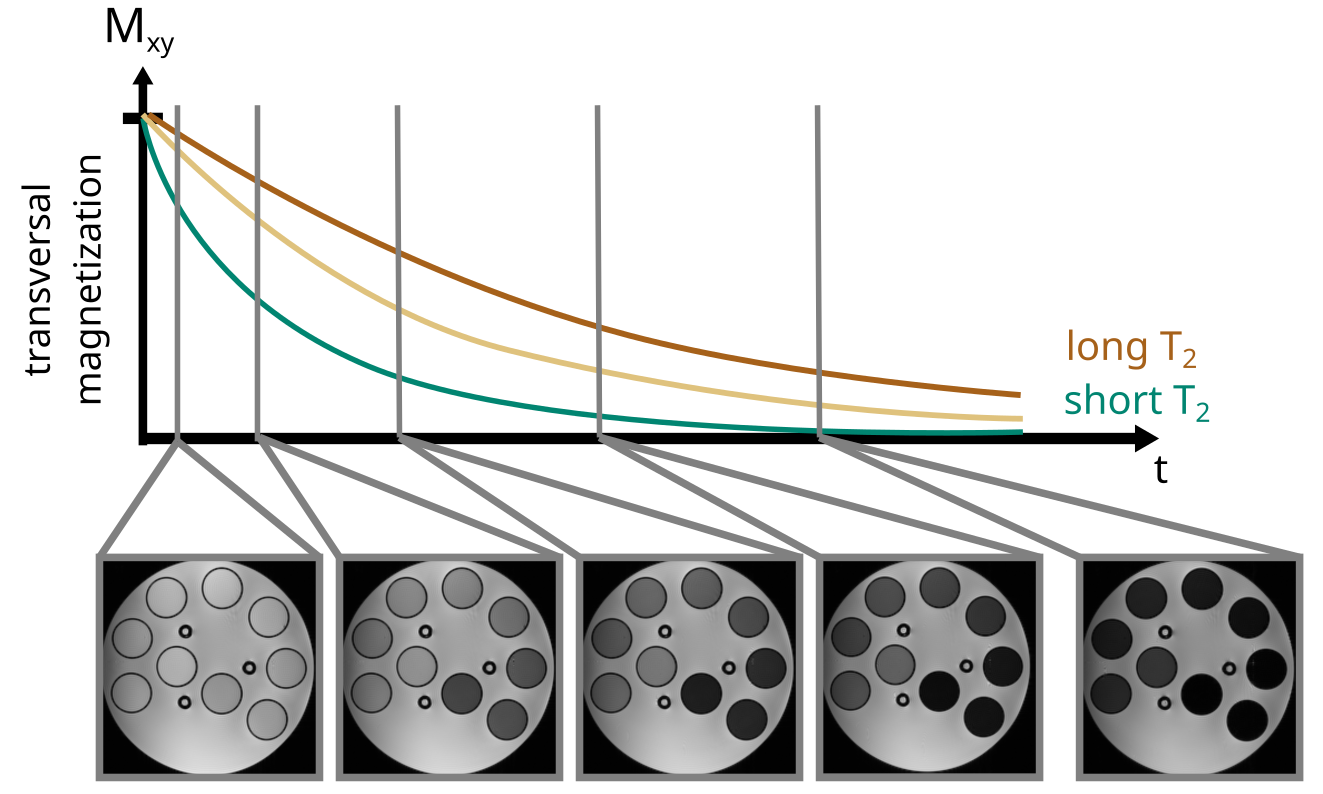

We can now define the different arguments according to our sequence.
- `-S` for a Spin Echo signal
- We have a `number  of echos` (`-n`) of `20`
- Use reasonable values for minimum and maximum T2 (`-2`) and we will use `1000` measurements.
- The `echo time` (`-e`) is `10 milliseconds`

In [ ]:
%%bash
N_MEASUREMENTS=20
MIN_T2=10e-3
MAX_T2=0.5
N_T2_POINTS=1000
ECHO_TIME=10e-3

bart signal -S -n${N_MEASUREMENTS} -2${MIN_T2}:${MAX_T2}:${N_T2_POINTS} -e${ECHO_TIME} signal

To have the correct format we need to transpose dimension `2` and `5` of our `bart signal` output and finally use `bart squeeze` on our signal. In the interest of time we'll take care of you for that!

In [ ]:
# Transposing and squeezing!
%%bash
bart transpose 2 5 signal - | bart squeeze - signal

Now we calculate the SVD of our signal using `bart svd`.

In [ ]:
%%bash
bart svd -h

We use the `-e` flag.

In [ ]:
# Your code here
%%bash
bart svd ...

# Output names: u s v

We now extract the first `4` orthonormal columns from `u` using `bart extract` on dimension `1`.

In [ ]:
%%bash
# You can play around with different values !
N_vec=3

bart extract 1 0 $N_vec u basis
bart show -m basis

# Output name: basis

As you might have seen in the dimensions of our computed basis, the coefficients are currently in the 1st and the time is in the 0th dimension.

For compatibility with BART we need to move the dimensions to their natural position within the 16 dimensions of a .cfl file.

- We use Use `bart transpose` to correct the dimensions:
  - `1` and `6` (coefficients in the 6th dimension)
  - `0` and `5` (time in the 5th dimension)

In [ ]:
# Transposing
%%bash
bart transpose 1 6 basis - | bart transpose 0 5 - basis
bart show -m basis

Now that we have our basis we need to create our coefficient map. We will do this using the BARTs **P**arallel **I**maging **C**ompressed **S**ensing tool: `pics`.

Lets check what `bart pics` actuall needs using the `-h` flag.

In [ ]:
%%bash
bart pics -h

Ok these are a lot of options but we almost have everything we need. We just need a sensitivity map. Since we only have one coil we can just create a BART file with only ones. We can use `bart ones` for this.

In [ ]:
%%bash
bart ones -h

In [ ]:
%%bash
bart ones 2 60 60 sens

Now we generate the coefficient map using `bart pics`.

- `-i` iterations `8`
- `-B` our basis `basis`

Input:
- `ksp_usp`
- `sens`

In [ ]:
# Your code here
%%bash
bart pics ...

# Output name coeff_map

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("coeff_map")

Ok the coefficient map looks fine - so now let us get back our images by multiplying our coefficients with our basis.

We use `bart fmac` for this and the `-s` flag along the `6th` dimension.

In [ ]:
# Your code here
%%bash
bart fmac ...

# Call your output reco_subspace

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("reco_subspace")

We compute our T2 map as before using `bart mobafit`.



In [ ]:
# Bart mobafit as before, we do this for you!
%%bash
bart mobafit --min 0.01 --min-flag $(bart bitmask 1) -i5 -T enc reco_subspace R2map_subspace

In [ ]:
# Parameter extraction, bart invert and thresholding
%%bash
bart slice 6 1 R2map_subspace - | bart invert - T2map_subspace

# threshold
bart slice 6 0 R2map_subspace - | bart threshold -B 0.01 - mask_subspace
bart fmac mask_subspace T2map_subspace T2map_subspace_masked


In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2map_subspace_masked", cmap='viridis')

This looks better, tough we still have some undersampling artefacts.

### Motion (Bonus)

So our reconstruction looks better but still not perfect. Especially on the edges of the phantom we can still see undersampling artefacts. Why is this the case?

Lets take a look at the image of our phantom along the first ten echos - for this we created a short movie before the conference so the problem is more obvious:

In [ ]:
! wget -q https://raw.githubusercontent.com/mritogether/ESMRMB2024_Hardware_to_Map/refs/heads/main/04_reconstruction_of_images_and_parameter_maps/notebooks/fig/motion.gif
from IPython.display import Image
Image(filename='motion.gif', width=500)

As we can see our phantom is _wobbling_ along the echo dimension and our reconstruction doesn't like that.

We can fix this using BART - however this reconstruction takes a little longer, because it's computationally intensive, so we will just show very quickly how it's done.

If you want more information please check out the following workshop dedicated to motion correction [ISMRM2024](https://github.com/mrirecon/bart-workshop/tree/master/ismrm_motion_2024) by Moritz Blumenthal.

## Motion Correction

For the motion correction we treat our data as non-Cartesian.
We use `bart reshape` to format our data for non-Cartesian reconstruction.

Then we use `bart traj` to generate our k-space trajectory for Cartesian acquisition.

In [ ]:
%%bash
# We treat the data as non cartesian:
bart reshape 7 1 60 60 ksp_usp ksp_usp_nc

# compute k-space trajectory for Cartesian acquisition
bart traj -x60 -y60 traj

Now we extract a reference image using `bart slice`.

In [ ]:
%%bash
bart slice 5 0 img_slice img_ref

We compute the affine motion model relative to echo 0 using `bart affinereg`.

We will use the following arguments:

- `-l` loop
- along dimension `5`
- `r` file of our images

In [ ]:
! bart affinereg -h

In [ ]:
%%bash
bart -l $(bart bitmask 5) -r img_slice affinereg -A img_ref img_slice mov2d

Now we apply the motion model to the images to confirm the _wiggling_ is gone using  `bart interpolate` with the `-A` flag for using the affine transform for interpolation.

In [ ]:
! bart interpolate -h

In [ ]:
%%bash
bart -l $(bart bitmask 5) -r img_slice interpolate -A 7 img_slice mov2d img_cor

In [ ]:
# You can try this at home!
# enable_plotly_in_cell()
# interactive_bart_plot("img_slice")

Ok let's take a look at the corrected images - again we created this gif before the workshop.

In [ ]:
! wget -q https://raw.githubusercontent.com/mritogether/ESMRMB2024_Hardware_to_Map/refs/heads/main/04_reconstruction_of_images_and_parameter_maps/notebooks/fig/motion_corr.gif
from IPython.display import Image
Image(filename='motion_corr.gif', width=500)

The corrected image looks good but in reality we need to apply the correction to k-space.

We do this using a script that comes with BART: `affine_kspace.sh`.
This script uses `bart fovshift` shift and rotates the trajectory with `bart fmac`.

In [ ]:
%%bash
./bart/scripts/affine_kspace.sh ksp_usp_nc traj mov2d ksp_usp_nc_cor traj_cor

Now we perform the reconstruction on the motion corrected k-space.
We again use `bart moba` and pass the corrected k-space and trajectory.

In [ ]:
# 3min
%%bash
bart moba -i20 -R3 -d4 -t traj_cor -T ksp_usp_nc_cor enc reco_moba_usp
bart slice 6 1 reco_moba_usp - | bart resize -c 0 60 1 60 - - | bart invert - T2map_moba_usp

In [ ]:
# threshold
%%bash
bart slice 6 0 reco_moba_usp - | bart resize -c 0 60 1 60 - - | bart threshold -B 0.1 - mask_moba_usp

bart threshold -M 0.5 T2map_moba_usp mask_moba_usp
bart fmac mask_moba_usp T2map_moba_usp T2map_moba_masked_usp

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2map_moba_masked_usp", cmap='viridis')

In [ ]:
%%bash
# Join to compare fully sampled and moba
bart join 1 T2map_moba_masked_usp T2map_moba_masked T2map_moba_compare

In [ ]:
enable_plotly_in_cell()
interactive_bart_plot("T2map_moba_compare", cmap='viridis')

Thank you for completing the Workshop on `Reconstruction of Images and Parameter Maps`!